In [1]:
from get_models import Progress_Bar, Encoder, Decoder, CovarianceMatrix, thermometer_encode_df

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import scipy.stats as stats
from scipy.stats import chi2

%load_ext autoreload
%autoreload 2

In [2]:
#vae latent dimension
latent_dim = 2

def get_ind(id, df):
    return np.where(df['patient_id'] == id)[0]

def get_design_matrix(df_effects, fixed_effects_keys, random_effects_keys, r=1, include_interaction=False):
    patient_id = df_effects['patient_id'].unique()

    X_list = [torch.from_numpy(np.array(df_effects.loc[get_ind(id, df_effects), fixed_effects_keys])).to(torch.float32) for id in patient_id]

    if include_interaction==True:
        for key in random_effects_keys[1:]:
            X_list = [torch.cat((X_i, X_i[:,1:] * torch.from_numpy(np.array(df_effects.loc[get_ind(patient_id[j], df_effects), key])).unsqueeze(-1)
                                ), -1).to(torch.float32) for j,X_i in enumerate(X_list)]

    X_list = [torch.cat((torch.from_numpy(np.array(df_effects.loc[get_ind(patient_id[j], df_effects), 'age'])).unsqueeze(-1), X_i), -1).to(torch.float32) for j,X_i in enumerate(X_list)]


    Z_list = [torch.from_numpy(np.array(df_effects.loc[get_ind(id, df_effects), random_effects_keys])).to(torch.float32) for id in patient_id]
    Z_list = [torch.block_diag(*[i for j in range(r)]) for i in Z_list]   
    X_list = [torch.block_diag(*[i for j in range(r)]) for i in X_list]
    return X_list, Z_list



In [3]:
# initialize Encoder and Decoder Models and the Mixed Model Parameters. mode='diagonal': Diagonal Covariance Matrix, mode='full': Full Covariance Matrix,
def initialize(latent_dim, mode='diagonal'):
    encoder = Encoder(
        input_dim=69,
        hidden_dims=[150], 
        output_dim=latent_dim, 
        act=torch.nn.Tanh())

    decoder = Decoder(
        item_positions=np.concatenate([[i]*a for i,a in enumerate(np.array(test_scores_df[test_scores_df.columns[1:]].max(0)).astype(np.int32))]),                            
        input_dim=latent_dim,
        hidden_dims=[150], 
        act=torch.nn.Tanh())

    var_param = CovarianceMatrix(q*latent_dim, mode=mode)    
    return encoder, decoder, var_param

In [4]:



#Train the VAE model:  Weighting of the loss function
# alpha: kl-divergence weight;  
# delta: MSE distance between encoder prediction and decoder; 
# gamma: decoder reconstruction loss
# eta: mixed model loss

# batch_size should be greater than 50

def train_vae(epochs, batch_size, encoder, decoder, optimizer_vae, alpha=1, gamma=1):
    steps = int(len(test_scores_df_encoded) / batch_size)
    rng = np.random.default_rng(1234)
    prior = Normal(torch.zeros(torch.Size([latent_dim])), torch.ones(torch.Size([latent_dim])))
    #progBar = Progress_Bar(epochs, steps, ['nELBO', 'KL', 'Rec Loss', 'Item Error'])
    
    for epoch in range(epochs):
        shuffle = rng.permutation(len(test_scores_df_encoded))
        
        for step in range(steps):
            pat_batch = np.arange(len(test_scores_df_encoded))[shuffle[step*batch_size:(step+1)*batch_size]]

            test_data = torch.from_numpy(np.array(test_scores_df_encoded.loc[pat_batch])).to(torch.float32)
            test_data_orig = torch.from_numpy(np.array(test_scores_df[test_scores_df.columns[1:]].loc[pat_batch])).to(torch.int32)
            
            optimizer_vae.zero_grad(set_to_none=True)
            #encode test scores
            mu, log_sig = encoder.encode(test_data)

            #reparametrization trick to get latent variables
            eps = prior.sample(torch.Size([log_sig.size(dim=0)])) 
            z = mu + log_sig.exp() * eps
            
            #kl divergence
            kl = torch.mean(0.5 * torch.sum(mu.square() + torch.exp(2.0 * log_sig) - 1.0 - (2.0 * log_sig), dim=1))

            rec_loss, probs = decoder(z, test_data_orig)
            nelbo = alpha * kl + gamma * rec_loss
                
            nelbo.backward()
            optimizer_vae.step()

            #data_pred = torch.stack([torch.argmax(pred, dim=-1) for pred in probs]) 
            # total test item prediction error  
            #item_error = np.mean(np.sum(np.abs(data_pred.detach().numpy() - test_data_orig.T.numpy()), axis=0))

            # progBar.update({
            #     'nELBO': nelbo.item(), 
            #     'KL': alpha * kl.item(), 
            #     'Rec Loss': gamma * rec_loss.item(), 
            #     'Item Error': item_error,
            #     }) 
    
    with torch.no_grad():
        mu = encoder.encode(torch.from_numpy(np.array(test_scores_df_encoded)).to(torch.float32))[0] 
        return mu.detach()


def calc_likelihood(var_param, Z_list_batch, X_list_batch, z_list):
    Phi, sigma = var_param()
    N = sum([len(Z_i) for Z_i in Z_list_batch])

    V_list = [Z_i @ Phi @ Z_i.t() + torch.eye(Z_i.size(0)) * sigma for Z_i in Z_list_batch]
    V_inv_list = [V_i.inverse() for V_i in V_list]
    
    Xt_V_inv_X = torch.stack([X_i.t() @ V_i_inv @ X_i for X_i, V_i_inv in zip(X_list_batch, V_inv_list)]).sum(dim=0)
    Xt_V_inv_y = torch.stack([X_i.t() @ V_i_inv @ y_i for X_i, V_i_inv, y_i in zip(X_list_batch, V_inv_list, z_list)]).sum(dim=0)

    #Check if Xt_V_inv_X is invertible. Only needed for mini batching
    if torch.abs(torch.det(Xt_V_inv_X)) > 1e-6:
        EBLUE = Xt_V_inv_X.inverse() @ Xt_V_inv_y
        #EBLUP_list = [Phi @ Z_i.t() @ V_i_inv @ (y_i - X_i @ EBLUE) for X_i, Z_i, V_i_inv, y_i in zip(X_list_batch, Z_list_batch, V_inv_list, z_list)]

        residual_list = [y_i - X_i @ EBLUE for y_i, X_i in zip(z_list, X_list_batch)]
        #Mixed model prediction
        #z_pred = torch.cat([X_i @ EBLUE + Z_i @ EBLUP_i for X_i, Z_i, EBLUP_i in zip(X_list_batch, Z_list_batch, EBLUP_list)]).reshape((-1, latent_dim))

        log_det_V = torch.stack([V_i.det().clamp(min=1e-12).log() for V_i in V_list]).sum()
        const = torch.log(torch.tensor(2.0 * torch.pi))
        rt_V_inv_r = torch.stack([r_i.t() @ V_i_inv @ r_i for r_i, V_i_inv in zip(residual_list, V_inv_list)]).sum()

        #negative mixed models likelihood
        nML = 0.5 * (log_det_V + rt_V_inv_r + N * const) #/ N   
         
    return nML 

In [5]:
def likelihood_ratio(L_full, L_red):
    return 2 * (L_full - L_red)

In [6]:
# RUN SIMULATION FOR n = num_simulations
num_simulations = 1000
lrt_results = [] # List to save the results

all_epochs_dict = {} #dictionary to save all models in only one frame

fixed_effects_keys_full = ['family_affected', 'sco_surg', '≤3', 'onset_age', 'presym_diag', 'presymptomatic', 'stand_lost', 'stand_gained', 'stand_never', 'sex']
random_effects_keys_full = ['intercept', 'since_medication', 'since_switch']
# reduced model without fixed effect 'sex' 
fixed_effects_keys_red = ['family_affected', 'sco_surg', '≤3', 'onset_age', 'presym_diag', 'presymptomatic', 'stand_lost', 'stand_gained', 'stand_never']
random_effects_keys_red = ['intercept', 'since_medication', 'since_switch']

q = len(random_effects_keys_full)

for i in range(num_simulations):
    print('epoch', i)
    #Load dataframes: test_scores has high dimensional test score data of hfsme tests
    test_scores_df = pd.read_csv(os.getcwd()+'/test_scores.csv')

    #test_scores_df_encoded is a thermometer encoding of test_scores_df for the encoder network
    test_scores_df_encoded = thermometer_encode_df(test_scores_df, test_scores_df.columns[1:])

    #time_df contains data that changes with time, e.g.: age or time since medication switch
    time_df = pd.read_csv(os.getcwd()+'/time_df.csv')
    time_df['intercept'] = np.ones(time_df.shape[0])

    #baseline_df contains features that characterizes patients at baseline
    baseline_df = pd.read_csv(os.getcwd()+'/baseline_df.csv')

    # 'sex' has no influence:
    baseline_df['sex'] = np.random.randint(2, size=baseline_df.shape[0])

    df_effects = pd.merge(baseline_df, time_df, on='patient_id', how='inner')
    
    patients = torch.from_numpy(np.array(baseline_df['patient_id']))
    num_patients = len(patients)
    
    # get design matrix for the full model
    X_list_full, Z_list_full = get_design_matrix(df_effects, fixed_effects_keys_full, random_effects_keys_full, r=latent_dim)
    # get design matrix for the reduced model
    X_list_red, Z_list_red = get_design_matrix(df_effects, fixed_effects_keys_red, random_effects_keys_red, r=latent_dim)   
    
    pat_ind = np.cumsum([0]+[int(len(X_i)/latent_dim) for X_i in X_list_full])
    
    

    print('\n', i)
    # reinitialize the parameters and the optimizer
    encoder, decoder = initialize(latent_dim)[0:2]
    optimizer_vae = torch.optim.Adam([ 
        {'params': encoder.parameters(), 'lr': 0.01},  
        {'params': decoder.parameters(), 'lr': 0.01},  
    ])
    
    var_param_full = CovarianceMatrix(q*latent_dim, mode='diagonal')    
    var_param_red = CovarianceMatrix(q*latent_dim, mode='diagonal')    
    
    optimizer_mm_full = torch.optim.Adam([ 
        {'params': var_param_full.parameters(), 'lr': 1.0}
    ])

    optimizer_mm_red = torch.optim.Adam([ 
        {'params': var_param_red.parameters(), 'lr': 1.0}
    ])
    
    z = train_vae(150, 100, encoder, decoder, optimizer_vae)

    pat_ind_b = [torch.arange(pat_ind[i],pat_ind[i+1]) for i in patients]
    z_list = [z[ind].flatten().to(torch.float32) for ind in pat_ind_b]
    
    steps = 300
    #progBar_full = Progress_Bar(steps, 1, ['nML'])
    #progBar_red = Progress_Bar(steps, 1, ['nML'])

    print('\nTrain full:')
    for j in range(steps):
        optimizer_mm_full.zero_grad(set_to_none=True)
        nML_full = calc_likelihood(var_param_full, Z_list_full, X_list_full, z_list)
        nML_full.backward()
        optimizer_mm_full.step()       
        # progBar_full.update({
        #     'nML': nML_full.item(), 
        #     }) 

    print('\nTrain reduced:')
    for k in range(steps):
        optimizer_mm_red.zero_grad(set_to_none=True)
        nML_red = calc_likelihood(var_param_red, Z_list_red, X_list_red, z_list)
        nML_red.backward()
        optimizer_mm_red.step()            
        # progBar_red.update({
        #     'nML': nML_red.item(), 
        #     }) 

    all_epochs_dict[f'epoch_{i}'] = {
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'var_param_full': var_param_full,
        'optimizer_vae_state_dict': optimizer_vae.state_dict(),
        'var_param_red': var_param_red,
        'optimizer_mm_full': optimizer_mm_full,
        'optimizer_mm_red': optimizer_mm_red,
        'X_list_full' : X_list_full,
        'Z_list_full' : Z_list_full,
        'X_list_red' : X_list_red,
        'Z_list_red' : Z_list_red,
        'z_list': z_list
    }

    print('\nLikelihood ratio:', likelihood_ratio(nML_full, nML_red))
    lrt_results.append(likelihood_ratio(nML_full, nML_red))

torch.save(all_epochs_dict, fr'C:\Users\yanni\OneDrive\Desktop\BachelorArbeit2024\Code\trained_models\vae_MM_getrennt_{num_simulations}_epochs.pth')

epoch 0

 0

Train full:

Train reduced:

Likelihood ratio: tensor(-0.5410, grad_fn=<MulBackward0>)
epoch 1

 1

Train full:

Train reduced:

Likelihood ratio: tensor(-0.7871, grad_fn=<MulBackward0>)
epoch 2

 2

Train full:

Train reduced:

Likelihood ratio: tensor(-2.9219, grad_fn=<MulBackward0>)
epoch 3

 3

Train full:

Train reduced:

Likelihood ratio: tensor(-6.5918, grad_fn=<MulBackward0>)
epoch 4

 4

Train full:

Train reduced:

Likelihood ratio: tensor(-3.6387, grad_fn=<MulBackward0>)
epoch 5

 5

Train full:

Train reduced:

Likelihood ratio: tensor(-3.4238, grad_fn=<MulBackward0>)
epoch 6

 6

Train full:

Train reduced:

Likelihood ratio: tensor(-6.5195, grad_fn=<MulBackward0>)
epoch 7

 7

Train full:

Train reduced:

Likelihood ratio: tensor(-4.2500, grad_fn=<MulBackward0>)
epoch 8

 8

Train full:

Train reduced:

Likelihood ratio: tensor(-0.0742, grad_fn=<MulBackward0>)
epoch 9

 9

Train full:

Train reduced:

Likelihood ratio: tensor(-0.0527, grad_fn=<MulBackward0>)


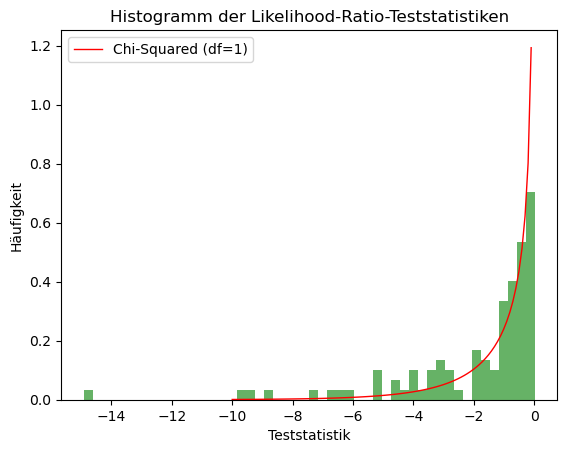

In [ ]:
# plot the histogr<am of the LRT-statistic
plt.hist(np.array(torch.stack(lrt_results).detach()), bins=50, density=True, alpha=0.6, color='g')

# x = np.linspace(-8000, 8000, 100)
# plt.plot(x, chi2.pdf(x + 500, df=1), 'r-', lw=2, label='Chi-Quadrat-Verteilung (df=1)')

x = np.linspace(0, 10, 100)
plt.plot(-x, chi2.pdf(x, df=1), 'r-', lw=1, label='Chi-Squared (df=1)')

# Beschriftungen hinzufügen
plt.title('Histogramm der Likelihood-Ratio-Teststatistiken')
plt.xlabel('Teststatistik')
plt.ylabel('Häufigkeit')
plt.legend()

# Histogramm anzeigen
plt.show()